In [1]:
#----------Öğrenciler Arasında Zihinsel Sağlık Eğilimlerinin Tespiti----------

# 1. Gerekli Kütüphanelerin İçe Aktarılması
# -------------------------------------------------

!pip install xgboost
!pip install lightgbm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, auc, roc_curve, precision_recall_curve, f1_score,log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score, matthews_corrcoef, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import plot_tree
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2. Veri Yükleme ve İlk İnceleme
# -------------------------------------------------
data = pd.read_csv("C:/Users/deger/Desktop/Veri_Seti.csv") 

print("Veri Seti Boyutu:", data.shape)
print("\nİlk 5 Satır:")
print(data.head())
print("\nVeri Seti Bilgileri:")
print(data.info())

Veri Seti Boyutu: (502, 11)

İlk 5 Satır:
   Gender   Age  Academic Pressure  Study Satisfaction     Sleep Duration  \
0    Male  28.0                2.0                 4.0          7-8 hours   
1     NaN  28.0                4.0                 5.0          5-6 hours   
2    Male  25.0                1.0                 3.0          5-6 hours   
3    Male  23.0                NaN                 4.0  More than 8 hours   
4  Female  31.0                NaN                 5.0  More than 8 hours   

  Dietary Habits Have you ever had suicidal thoughts ?  Study Hours  \
0       Moderate                                   NaN          9.0   
1        Healthy                                   Yes          7.0   
2      Unhealthy                                   Yes         10.0   
3      Unhealthy                                   Yes          NaN   
4        Healthy                                   Yes          4.0   

   Financial Stress Family History of Mental Illness Depression  
0 


Hedef değişken: Depression


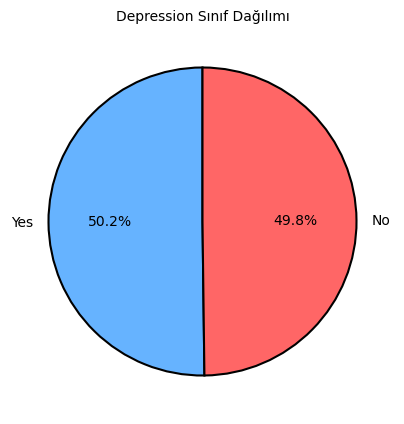

In [3]:
# Hedef değişkeni belirleme
target_column = 'Depression'  # Hedef Sütun
print("\nHedef değişken:", target_column)

# Sınıf dağılımı
class_distribution = data['Depression'].value_counts()

plt.figure(figsize=(5, 5))
class_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666'], 
                        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
plt.title('Depression Sınıf Dağılımı', fontsize=10)
plt.ylabel('') 
plt.show()


Eksik Veri Analizi:
Gender                                   52
Age                                      54
Academic Pressure                        51
Study Satisfaction                       43
Sleep Duration                           46
Dietary Habits                           46
Have you ever had suicidal thoughts ?    59
Study Hours                              59
Financial Stress                         59
Family History of Mental Illness         58
Depression                                0
dtype: int64


<Axes: title={'center': 'Eksik Veri Isı Haritası'}>

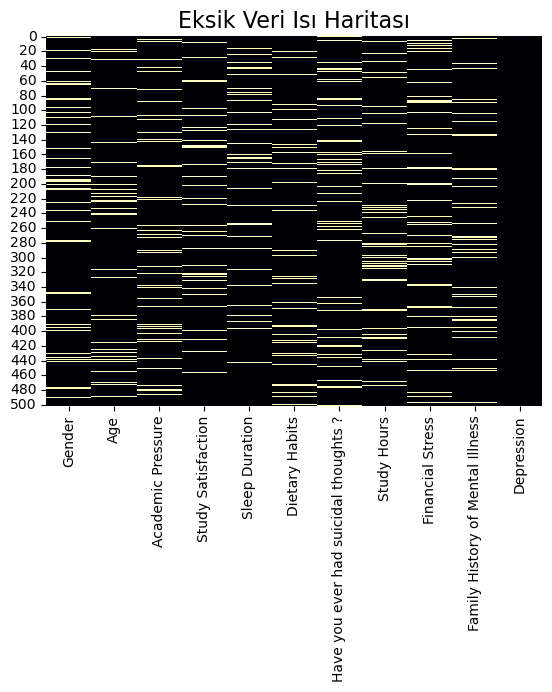

In [4]:
# Eksik Veri Analizi
print("\nEksik Veri Analizi:")
print(data.isnull().sum())

plt.title('Eksik Veri Isı Haritası', fontsize=16)
sns.heatmap(data.isnull(), cbar=False, cmap='magma')


In [5]:
# 3. Veri Ön İşleme
# -------------------------------------------------
# Sayısal değerler için
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
knn_imputer = KNNImputer(n_neighbors=5)
data[numeric_columns] = knn_imputer.fit_transform(data[numeric_columns])
data[numeric_columns]= np.round(data[numeric_columns])

# Kategorik değerler için
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

print("\nİlk 5 Satır:")
print(data.head())


İlk 5 Satır:
   Gender   Age  Academic Pressure  Study Satisfaction     Sleep Duration  \
0    Male  28.0                2.0                 4.0          7-8 hours   
1    Male  28.0                4.0                 5.0          5-6 hours   
2    Male  25.0                1.0                 3.0          5-6 hours   
3    Male  23.0                4.0                 4.0  More than 8 hours   
4  Female  31.0                3.0                 5.0  More than 8 hours   

  Dietary Habits Have you ever had suicidal thoughts ?  Study Hours  \
0       Moderate                                   Yes          9.0   
1        Healthy                                   Yes          7.0   
2      Unhealthy                                   Yes         10.0   
3      Unhealthy                                   Yes          3.0   
4        Healthy                                   Yes          4.0   

   Financial Stress Family History of Mental Illness Depression  
0               2.0           

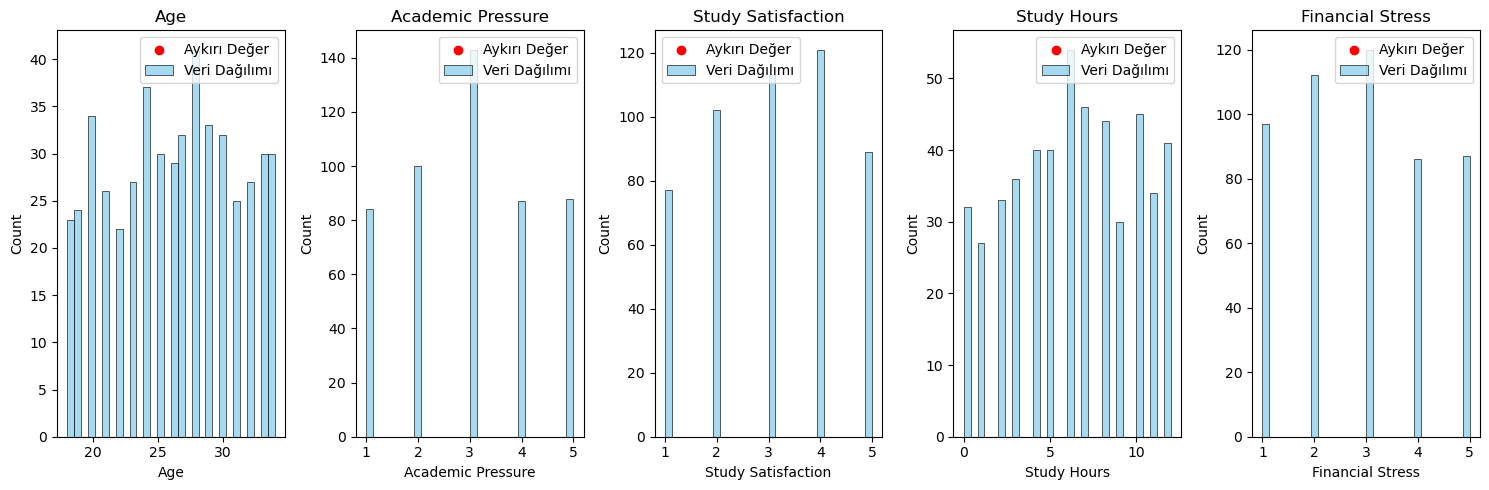

In [6]:
# Aykırı değer analizi
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_columns):
    plt.subplot(1, len(numeric_columns), i + 1)
    
    # Histogram ve KDE
    sns.histplot(data[col], kde=False, color='skyblue', bins=30, label='Veri Dağılımı')
    
    # Aykırı değerleri kırmızı noktalarla işaretle
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
    plt.scatter(outliers, [0] * len(outliers), color='red', label='Aykırı Değer', zorder=10)
    
    plt.title(f"{col}")
    plt.legend()

plt.tight_layout()
plt.show()


Veri Seti Boyutu: (502, 16)


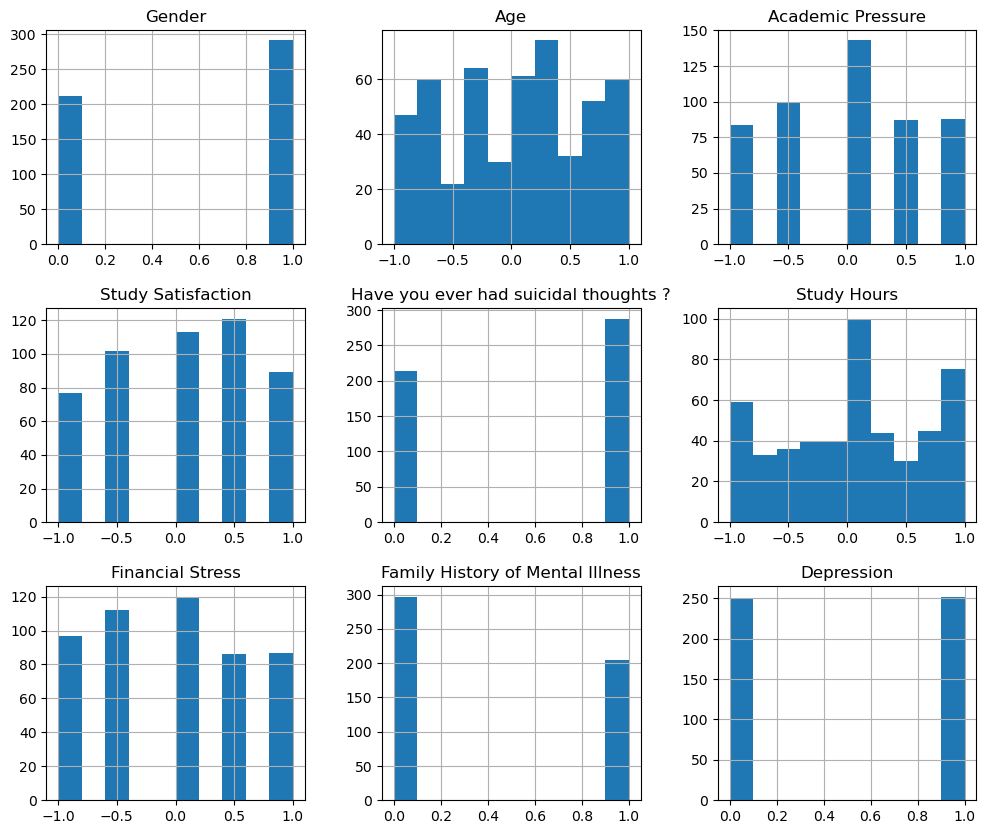

In [80]:
# 3. Veri Ön İşleme
# -------------------------------------------------
# Normalizasyon için RobustScaler
scaler = RobustScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Veri seti son hali
print("Veri Seti Boyutu:", data.shape)
data.hist(figsize=(12, 10))
plt.show()

In [9]:
# Kategorik değişkenler için gelişmiş kodlama
categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {} 
for col in categorical_columns:    
    if data[col].nunique() <= 2:
        label_encoders[col] = LabelEncoder()
        data[col] = label_encoders[col].fit_transform(data[col])
    else:
        data = pd.get_dummies(data, columns=[col], prefix=col)


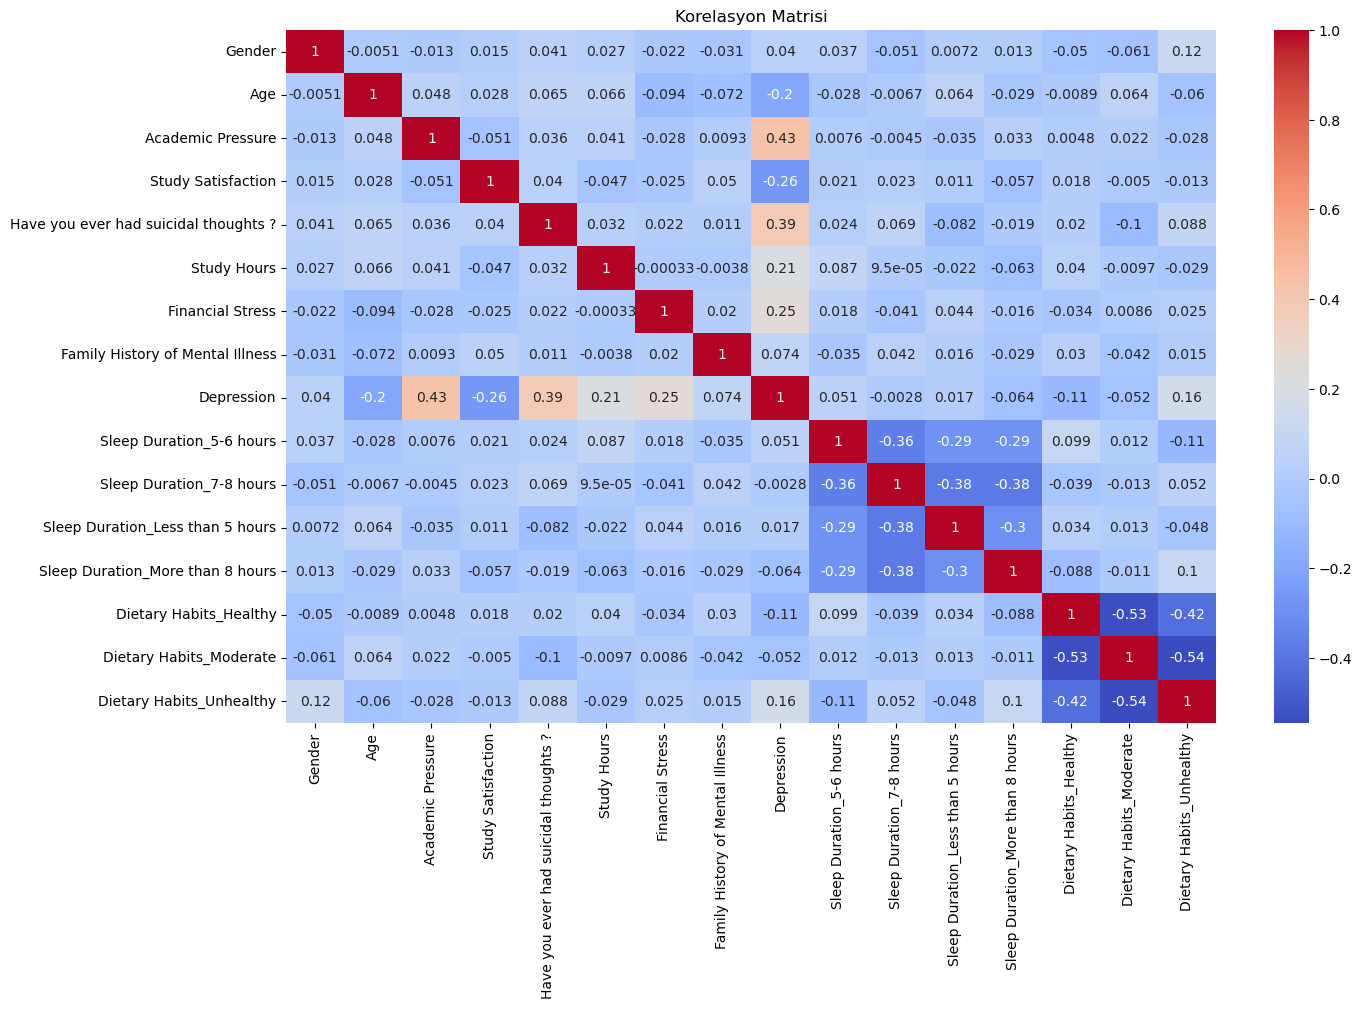

In [10]:
# Korelasyon matrisi
plt.figure(figsize=(15, 9))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Korelasyon Matrisi")
plt.show()

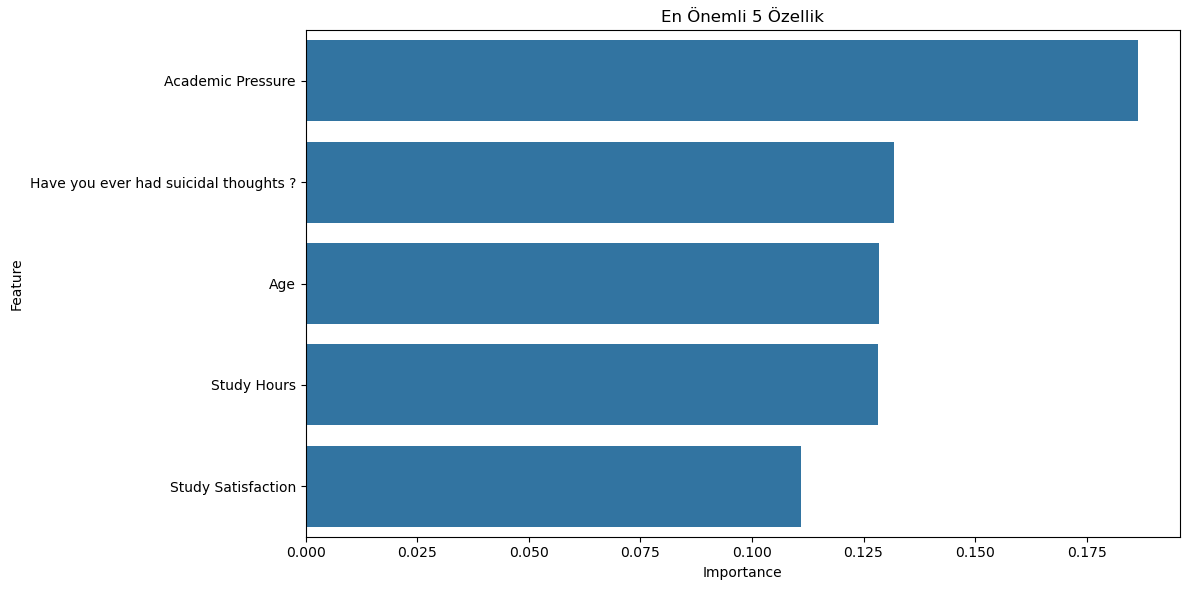

In [11]:
# 4. Özellik Seçimi ve Önem Analizi
# -------------------------------------------------
X = data.drop('Depression', axis=1)
y = data['Depression']

# Random Forest ile özellik önem dereceleri
rf_importance = RandomForestClassifier(n_estimators=100, random_state=42)
rf_importance.fit(X, y)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_importance.feature_importances_
}).sort_values('Importance', ascending=False)

# En önemli özelliklerin görselleştirilmesi
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(5), x='Importance', y='Feature')
plt.title('En Önemli 5 Özellik')
plt.tight_layout()
plt.show()

In [12]:
# 6. Veri Bölme
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [13]:
# 7.1 Random Forest Modeli için Manuel Parametreyle Eğitim
model = RandomForestClassifier(n_estimators=50, max_depth= 20, min_samples_split=5, min_samples_leaf=2)
model.fit(X_train, y_train)
print("Score:")
print(model.score(X_test, y_test))


Score:
0.8514851485148515


In [14]:
print("Random Forest Modeli Hiperparametre Optimizasyonu...")

# Her model için optimize edilmiş sonuçları saklayacak sözlük
best_models = {}

# Random Forest için hiperparametre arama alanı
rf_params = {
    'n_estimators': [100, 150, 200],  
    'max_depth': [5, 10, 20],  
    'min_samples_split': [10, 20], 
    'min_samples_leaf': [2, 4, 8]  
}

grid_search_rf = GridSearchCV(
        RandomForestClassifier(), rf_params, cv=10, scoring='f1',
        n_jobs=1
)

grid_search_rf.fit(X_train, y_train)
best_models['Random Forest'] = grid_search_rf.best_estimator_

print(f"En iyi parametreler: {grid_search_rf.best_params_}")
print(f"En iyi çapraz doğrulama skoru: {grid_search_rf.best_score_:.4f}")


Random Forest Modeli Hiperparametre Optimizasyonu...
En iyi parametreler: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 200}
En iyi çapraz doğrulama skoru: 0.8645


In [15]:
# 7.2 SVC Modeli Manuel Parametreyle Eğitim
model = SVC(kernel='poly', C=0.1, gamma='scale')
model.fit(X_train, y_train)
print(f"Score:")
model.score(X_test,y_test)

Score:


0.8316831683168316

In [16]:
# SVC Modeli ve Hiperparametre Optimizasyonu
print("SVC Modeli Hiperparametre Optimizasyonu...")

# SVC için hiperparametre alanı
svc_params = {
    'C': [0.1, 1, 10],  # Düzenlileştirme parametresi
    'kernel': ['linear', 'rbf', 'poly'],  # Çekirdek türü
    'gamma': ['scale', 'auto'],  # Kernel için gamma değeri
}

grid_search_svc = GridSearchCV(
        SVC(random_state=42, probability=True), svc_params, cv=5, scoring='f1',
        n_jobs=1
)

grid_search_svc.fit(X_train, y_train)
best_models['SVC'] = grid_search_svc.best_estimator_

print(f"En iyi parametreler: {grid_search_svc.best_params_}")
print(f"En iyi çapraz doğrulama skoru: {grid_search_svc.best_score_:.4f}")

SVC Modeli Hiperparametre Optimizasyonu...
En iyi parametreler: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
En iyi çapraz doğrulama skoru: 0.8758


In [17]:
model = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split= 2, min_samples_leaf= 1)
model.fit(X_train, y_train)
print(f"Score:")
model.score(X_test,y_test)

Score:


0.7722772277227723

In [18]:
# 7.3 Decision Tree Modeli için Hiperparametreyle Eğitim

print("Decision Tree Modeli Hiperparametre Optimizasyonu...")

# Decision Tree için hiperparametre arama alanı
dt_params = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2],  
    'criterion': ['gini', 'entropy']  
}

grid_search_dt = GridSearchCV(
        DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='f1',
        n_jobs=1
)
grid_search_dt.fit(X_train, y_train)

best_models['Decision Tree'] = grid_search_dt.best_estimator_

print(f"En iyi parametreler: {grid_search_dt.best_params_}")
print(f"En iyi çapraz doğrulama skoru: {grid_search_dt.best_score_:.4f}")


Decision Tree Modeli Hiperparametre Optimizasyonu...
En iyi parametreler: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
En iyi çapraz doğrulama skoru: 0.7389


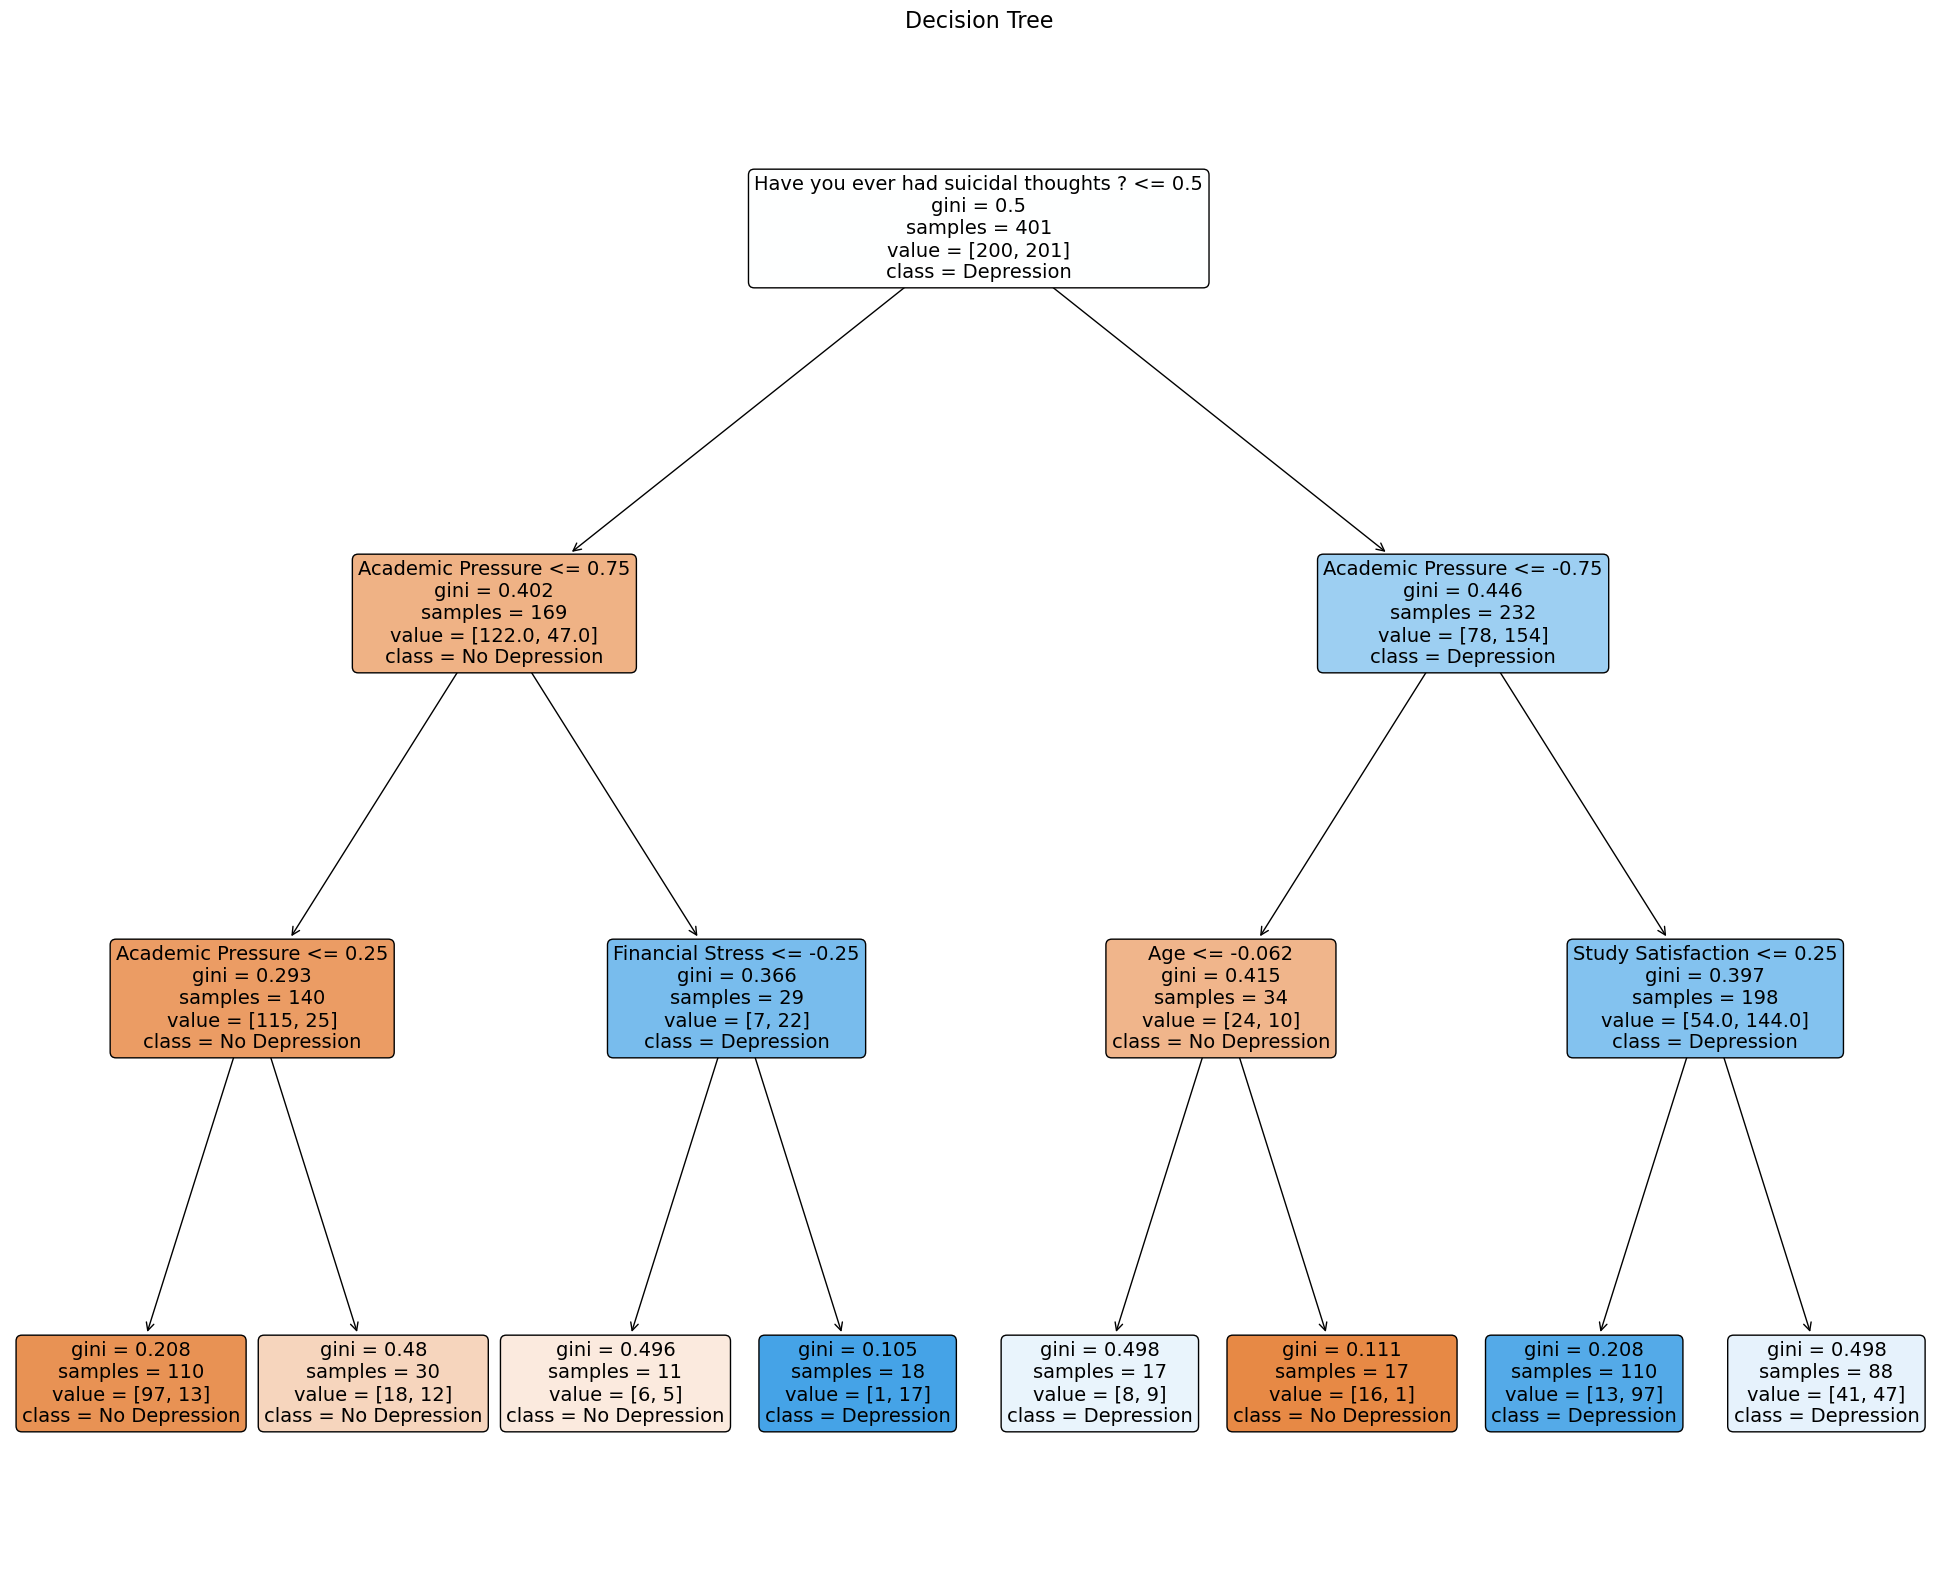

In [19]:
# Modeli görselleştirme
model = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split= 2, min_samples_leaf= 1)
model.fit(X_train, y_train)

plt.figure(figsize=(25, 20))
plot_tree(model, 
          feature_names=X_train.columns, 
          class_names=['No Depression', 'Depression'], 
          filled=True, 
          rounded=True, 
          fontsize=14)
plt.title('Decision Tree', fontsize=16)
plt.show()


In [20]:
# 7.4 Logistic Regression Modeli için Manuel Parametreyle Eğitim
model = LogisticRegression(solver= 'lbfgs', penalty= 'l2', max_iter= 300, C= 10)
model.fit(X_train, y_train)
print("Score:")
print(model.score(X_test, y_test))


Score:
0.8712871287128713


In [21]:
print("Logistic Regresyon Modeli Hiperparametre Optimizasyonu...")

# Logistic Regression için hiperparametre arama alanı
lr_params = {
    'penalty': ['l2', 'l1'],
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 200, 300]
}

grid_search_lr = GridSearchCV(
        LogisticRegression(random_state=42), lr_params, cv=5, scoring='f1',
        n_jobs=1
)

grid_search_lr.fit(X_train, y_train)
best_models['Logistic Regresyon'] = grid_search_lr.best_estimator_

print(f"En iyi parametreler: {grid_search_lr.best_params_}")
print(f"En iyi çapraz doğrulama skoru: {grid_search_lr.best_score_:.4f}")


Logistic Regresyon Modeli Hiperparametre Optimizasyonu...
En iyi parametreler: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
En iyi çapraz doğrulama skoru: 0.8754


In [22]:
# 7.5 Gradient Boosting Modeli için Manuel Parametreyle Eğitim
model = GradientBoostingClassifier(n_estimators=200, max_depth= 7, learning_rate=0.3, min_samples_split=2)
model.fit(X_train, y_train)
print("Score:")
print(model.score(X_test, y_test))


Score:
0.8613861386138614


In [23]:
print("Gradient Boosting Modeli Hiperparametre Optimizasyonu...")

# Gradient Boosting için hiperparametre arama alanı
gb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'min_samples_split': [2, 5, 10]
}

grid_search_gb = GridSearchCV(
        GradientBoostingClassifier(random_state=42), gb_params, cv=5, scoring='f1',
        n_jobs=1
)

grid_search_gb.fit(X_train, y_train)
best_models['Gradient Boosting'] = grid_search_gb.best_estimator_

print(f"En iyi parametreler: {grid_search_gb.best_params_}")
print(f"En iyi çapraz doğrulama skoru: {grid_search_gb.best_score_:.4f}")


Gradient Boosting Modeli Hiperparametre Optimizasyonu...
En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}
En iyi çapraz doğrulama skoru: 0.8505


In [24]:
# 7.6 XGBoost Modeli için Manuel Parametreyle Eğitim
model = XGBClassifier(n_estimators=100, max_depth= 7, learning_rate=0.3, subsample=1.0)
model.fit(X_train, y_train)

print("Score:")
print(model.score(X_test, y_test))


Score:
0.900990099009901


In [25]:
print("XGBoost Modeli Hiperparametre Optimizasyonu...")

# XGBoost için hiperparametre arama alanı
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search_xgb = GridSearchCV(
        XGBClassifier(random_state=42), xgb_params, cv=10, scoring='f1',
        n_jobs=1
)

grid_search_xgb.fit(X_train, y_train)
best_models['XGBoost'] = grid_search_xgb.best_estimator_

print(f"En iyi parametreler: {grid_search_xgb.best_params_}")
print(f"En iyi çapraz doğrulama skoru: {grid_search_xgb.best_score_:.4f}")


XGBoost Modeli Hiperparametre Optimizasyonu...
En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
En iyi çapraz doğrulama skoru: 0.8460


In [78]:
# 7.7 LightGBM Modeli için Manuel Parametreyle Eğitim
model = LGBMClassifier(n_estimators=300, max_depth= 7, learning_rate=0.3, num_leaves=100,verbose=-1)
model.fit(X_train, y_train)

print("Score:")
print(model.score(X_test, y_test))


Score:
0.8613861386138614


In [27]:
print("LightGBM Modeli Hiperparametre Optimizasyonu...")

# LightGBM için hiperparametre arama alanı
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'num_leaves': [30, 50, 100],
    'verbose': [-1],  # Uyarı mesajlarını gizler
}

grid_search_lgbm = GridSearchCV(
        LGBMClassifier(random_state=42), lgbm_params, cv=5, scoring='f1',
        n_jobs=1
)

grid_search_lgbm.fit(X_train, y_train)
best_models['LightGBM'] = grid_search_lgbm.best_estimator_

print(f"En iyi parametreler: {grid_search_lgbm.best_params_}")
print(f"En iyi çapraz doğrulama skoru: {grid_search_lgbm.best_score_:.4f}")


LightGBM Modeli Hiperparametre Optimizasyonu...
En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 30, 'verbose': -1}
En iyi çapraz doğrulama skoru: 0.8457



Decision Tree Model Değerlendirmesi:

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        50
           1       0.75      0.80      0.77        51

    accuracy                           0.76       101
   macro avg       0.76      0.76      0.76       101
weighted avg       0.76      0.76      0.76       101


Cross-Validation F1 Scores: [0.77647059 0.68493151 0.66666667 0.79012346 0.77647059]
Mean Cross-Validation F1 Score: 0.7389

Log-Loss: 5.5144


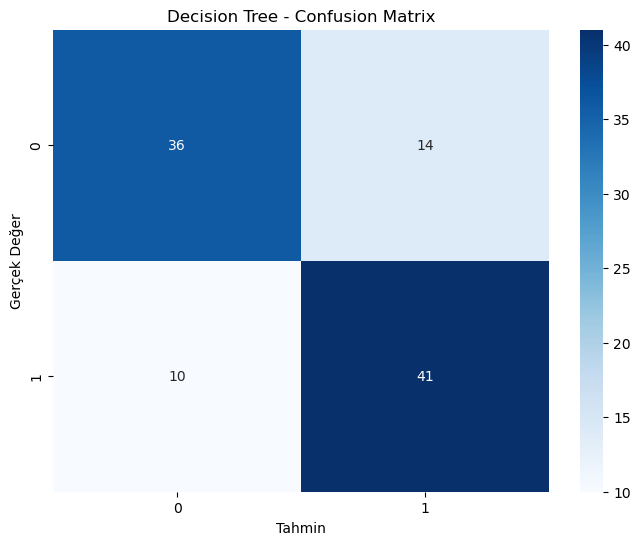

In [28]:
# 8. Model Değerlendirme
# -------------------------------------------------
#8.1 Decision Tree
print("\nDecision Tree Model Değerlendirmesi:")
best_dt=best_models['Decision Tree']
# Tahminler
y_pred = best_dt.predict(X_test)
y_prob = best_dt.predict_proba(X_test)[:, 1]

# Temel metrikler
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Cross-validation score
cv_scores = cross_val_score(best_dt, X_train, y_train, cv=5, scoring='f1')
print(f"\nCross-Validation F1 Scores: {cv_scores}")
print(f"Mean Cross-Validation F1 Score: {cv_scores.mean():.4f}")

# Log loss
logloss = log_loss(y_test, y_prob)
print(f"\nLog-Loss: {logloss:.4f}")

# Confusion Matrix görselleştirme
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree - Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin')
plt.show()




SVC Model Değerlendirmesi:

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87        50
           1       0.90      0.84      0.87        51

    accuracy                           0.87       101
   macro avg       0.87      0.87      0.87       101
weighted avg       0.87      0.87      0.87       101


Cross-Validation F1 Scores: [0.875      0.83544304 0.83544304 0.88095238 0.95238095]
Mean Cross-Validation F1 Score: 0.8758

Log-Loss: 0.3011


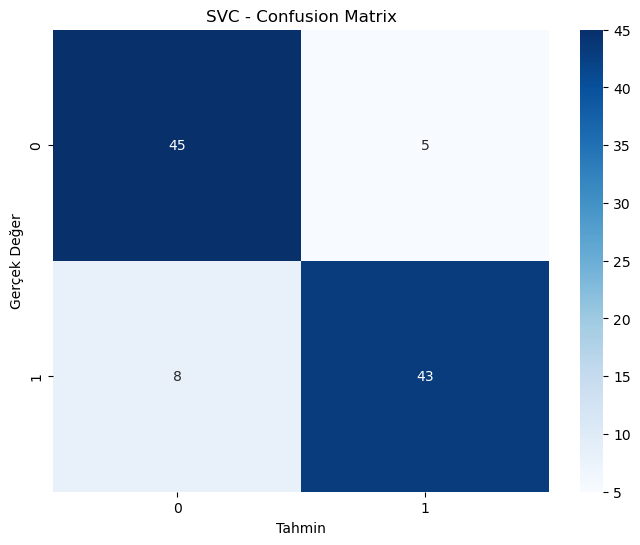

In [29]:
#8.2 SVC 
print("\nSVC Model Değerlendirmesi:")
best_svc=best_models['SVC']
# Tahminler
y_pred = best_svc.predict(X_test)
y_prob = best_svc.predict_proba(X_test)[:, 1]

# Temel metrikler
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Cross-validation score
cv_scores = cross_val_score(best_svc, X_train, y_train, cv=5, scoring='f1')
print(f"\nCross-Validation F1 Scores: {cv_scores}")
print(f"Mean Cross-Validation F1 Score: {cv_scores.mean():.4f}")

# Log loss
logloss = log_loss(y_test, y_prob)
print(f"\nLog-Loss: {logloss:.4f}")

# Confusion Matrix görselleştirme
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVC - Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin')
plt.show()



Logistic Regresyon Model Değerlendirmesi:

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87        50
           1       0.90      0.84      0.87        51

    accuracy                           0.87       101
   macro avg       0.87      0.87      0.87       101
weighted avg       0.87      0.87      0.87       101


Cross-Validation F1 Scores: [0.875      0.83544304 0.85714286 0.89156627 0.91764706]
Mean Cross-Validation F1 Score: 0.8754

Log-Loss: 0.3043


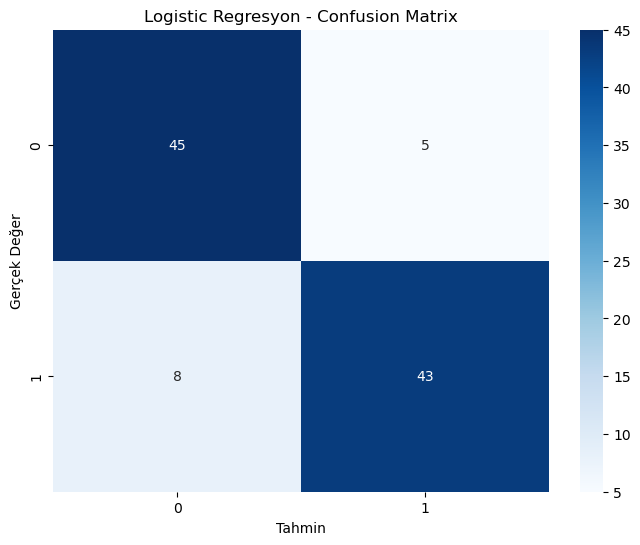

In [30]:
#8.3 Logistic Regresyon 
print("\nLogistic Regresyon Model Değerlendirmesi:")
best_lr=best_models['Logistic Regresyon']
# Tahminler
y_pred = best_lr.predict(X_test)
y_prob = best_lr.predict_proba(X_test)[:, 1]

# Temel metrikler
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Cross-validation score
cv_scores = cross_val_score(best_lr, X_train, y_train, cv=5, scoring='f1')
print(f"\nCross-Validation F1 Scores: {cv_scores}")
print(f"Mean Cross-Validation F1 Score: {cv_scores.mean():.4f}")

# Log loss
logloss = log_loss(y_test, y_prob)
print(f"\nLog-Loss: {logloss:.4f}")

# Confusion Matrix görselleştirme
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regresyon - Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin')
plt.show()



Random Forest Model Değerlendirmesi:

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        50
           1       0.87      0.88      0.87        51

    accuracy                           0.87       101
   macro avg       0.87      0.87      0.87       101
weighted avg       0.87      0.87      0.87       101


Cross-Validation F1 Scores: [0.83544304 0.79487179 0.8        0.84337349 0.85714286]
Mean Cross-Validation F1 Score: 0.8262

Log-Loss: 0.4629


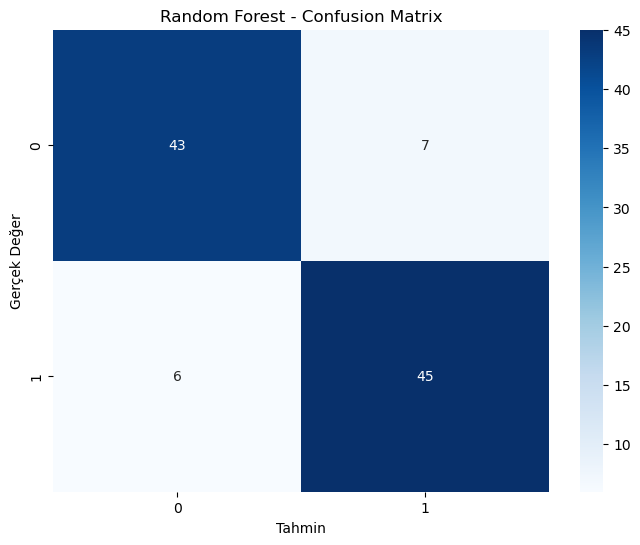

In [31]:
#8.4 Random Forest 
print("\nRandom Forest Model Değerlendirmesi:")
best_rf=best_models['Random Forest']
# Tahminler
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

# Temel metrikler
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Cross-validation score
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='f1')
print(f"\nCross-Validation F1 Scores: {cv_scores}")
print(f"Mean Cross-Validation F1 Score: {cv_scores.mean():.4f}")

# Log loss
logloss = log_loss(y_test, y_prob)
print(f"\nLog-Loss: {logloss:.4f}")

# Confusion Matrix görselleştirme
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin')
plt.show()



Gradient Boosting Model Değerlendirmesi:

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        50
           1       0.84      0.92      0.88        51

    accuracy                           0.87       101
   macro avg       0.88      0.87      0.87       101
weighted avg       0.87      0.87      0.87       101


Cross-Validation F1 Scores: [0.86746988 0.84615385 0.83116883 0.85714286 0.85057471]
Mean Cross-Validation F1 Score: 0.8505

Log-Loss: 0.3536


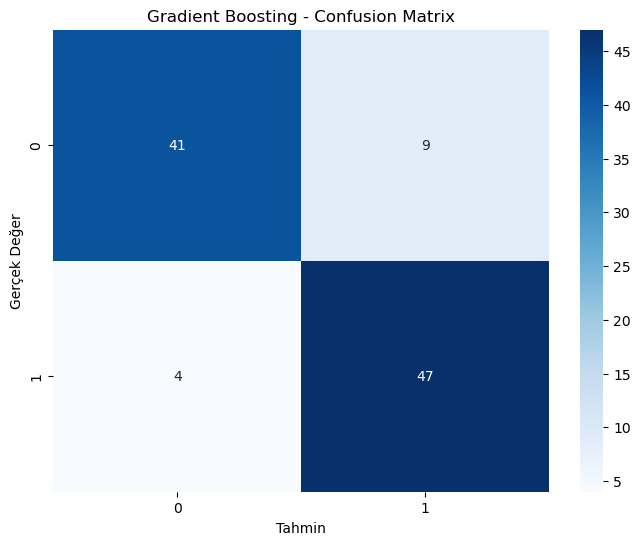

In [32]:
#8.5 Gradient Boosting 
print("\nGradient Boosting Model Değerlendirmesi:")
best_gb=best_models['Gradient Boosting']
# Tahminler
y_pred = best_gb.predict(X_test)
y_prob = best_gb.predict_proba(X_test)[:, 1]

# Temel metrikler
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Cross-validation score
cv_scores = cross_val_score(best_gb, X_train, y_train, cv=5, scoring='f1')
print(f"\nCross-Validation F1 Scores: {cv_scores}")
print(f"Mean Cross-Validation F1 Score: {cv_scores.mean():.4f}")

# Log loss
logloss = log_loss(y_test, y_prob)
print(f"\nLog-Loss: {logloss:.4f}")

# Confusion Matrix görselleştirme
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Gradient Boosting - Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin')
plt.show()



XGBoost Model Değerlendirmesi:

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88        50
           1       0.86      0.94      0.90        51

    accuracy                           0.89       101
   macro avg       0.90      0.89      0.89       101
weighted avg       0.89      0.89      0.89       101


Cross-Validation F1 Scores: [0.85       0.80519481 0.82051282 0.83950617 0.8372093 ]
Mean Cross-Validation F1 Score: 0.8305

Log-Loss: 0.3813


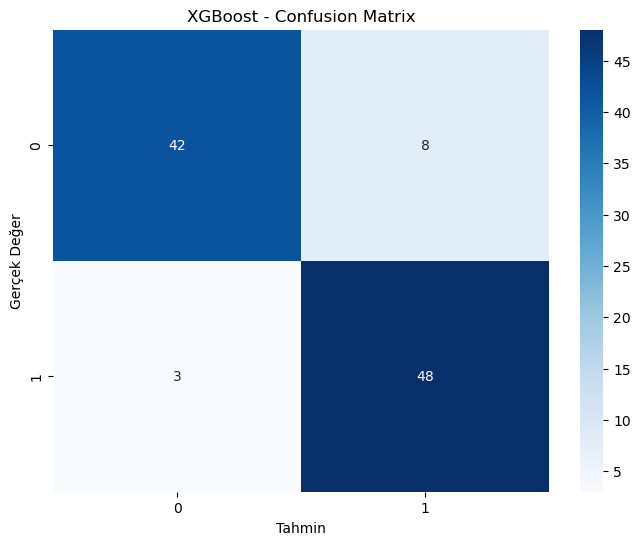

In [33]:
#8.6 XGBoost 
print("\nXGBoost Model Değerlendirmesi:")
best_xgb=best_models['XGBoost']
# Tahminler
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# Temel metrikler
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Cross-validation score
cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='f1')
print(f"\nCross-Validation F1 Scores: {cv_scores}")
print(f"Mean Cross-Validation F1 Score: {cv_scores.mean():.4f}")

# Log loss
logloss = log_loss(y_test, y_prob)
print(f"\nLog-Loss: {logloss:.4f}")

# Confusion Matrix görselleştirme
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost - Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin')
plt.show()




LightGBM Model Değerlendirmesi:

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88        50
           1       0.85      0.92      0.89        51

    accuracy                           0.88       101
   macro avg       0.88      0.88      0.88       101
weighted avg       0.88      0.88      0.88       101


Cross-Validation F1 Scores: [0.85365854 0.83544304 0.81481481 0.86075949 0.86363636]
Mean Cross-Validation F1 Score: 0.8457

Log-Loss: 0.3266


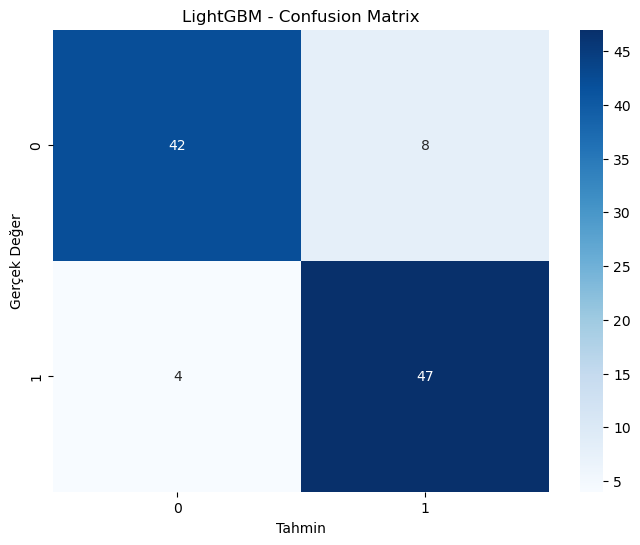

In [34]:
#8.7 LightGBM 
print("\nLightGBM Model Değerlendirmesi:")
best_lgbm=best_models['LightGBM']
# Tahminler
y_pred = best_lgbm.predict(X_test)
y_prob = best_lgbm.predict_proba(X_test)[:, 1]

# Temel metrikler
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Cross-validation score
cv_scores = cross_val_score(best_lgbm, X_train, y_train, cv=5, scoring='f1')
print(f"\nCross-Validation F1 Scores: {cv_scores}")
print(f"Mean Cross-Validation F1 Score: {cv_scores.mean():.4f}")

# Log loss
logloss = log_loss(y_test, y_prob)
print(f"\nLog-Loss: {logloss:.4f}")

# Confusion Matrix görselleştirme
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LightGBM - Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin')
plt.show()



Ensemble Model Değerlendirmesi:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89        50
           1       0.87      0.92      0.90        51

    accuracy                           0.89       101
   macro avg       0.89      0.89      0.89       101
weighted avg       0.89      0.89      0.89       101


Cross-Validation F1 Scores: [0.87804878 0.84615385 0.81481481 0.875      0.85393258]
Mean Cross-Validation F1 Score: 0.8536

Log-Loss: 0.3266


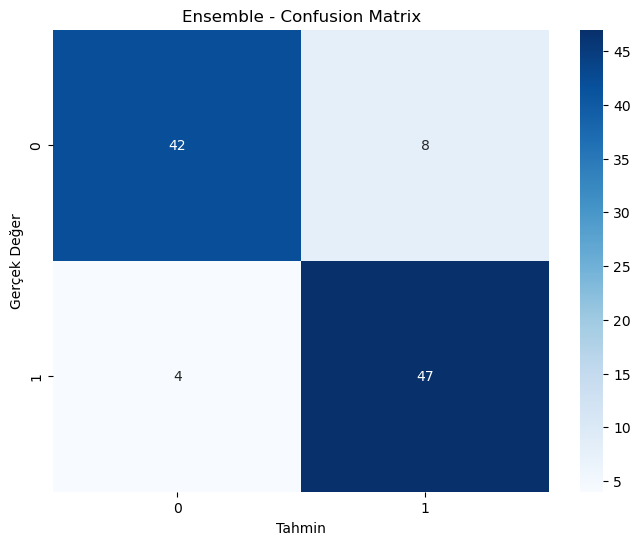

In [35]:
# 9. Ensemble Model Oluşturma
# -------------------------------------------------
# En iyi modellerden Voting Classifier oluşturma
voting_clf = VotingClassifier(
    estimators=[(f"model_{i}", model.best_estimator_ if isinstance(model, GridSearchCV) else model) 
                for i, (name, model) in enumerate(best_models.items())],
    voting='soft'
)

# Ensemble modelini eğitme
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
best_models['Ensemble Model'] = voting_clf
best_esb=best_models['Ensemble Model']
print("\nEnsemble Model Değerlendirmesi:")
print(classification_report(y_test, y_pred_voting))

# Cross-validation score
cv_scores = cross_val_score(best_esb, X_train, y_train, cv=5, scoring='f1')
print(f"\nCross-Validation F1 Scores: {cv_scores}")
print(f"Mean Cross-Validation F1 Score: {cv_scores.mean():.4f}")

# Log loss
logloss = log_loss(y_test, y_prob)
print(f"\nLog-Loss: {logloss:.4f}")

# Confusion Matrix görselleştirme
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Ensemble - Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin')
plt.show()


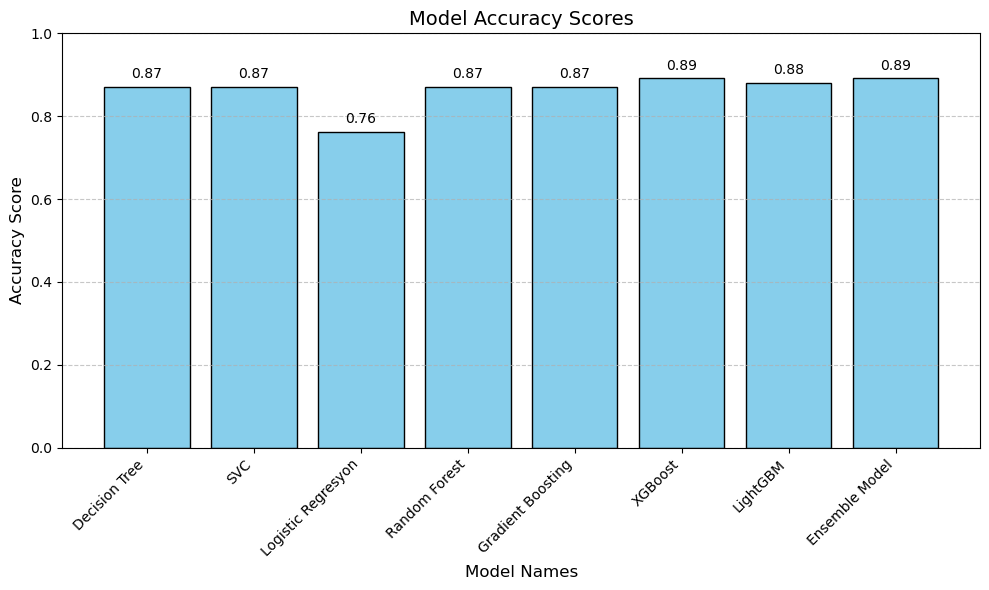

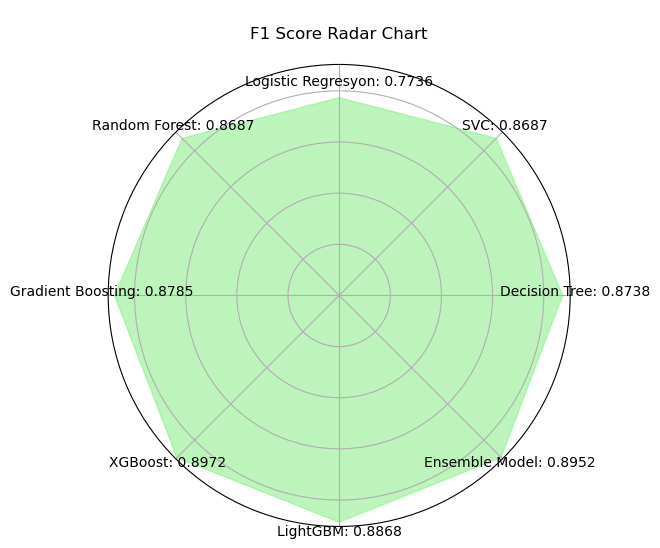

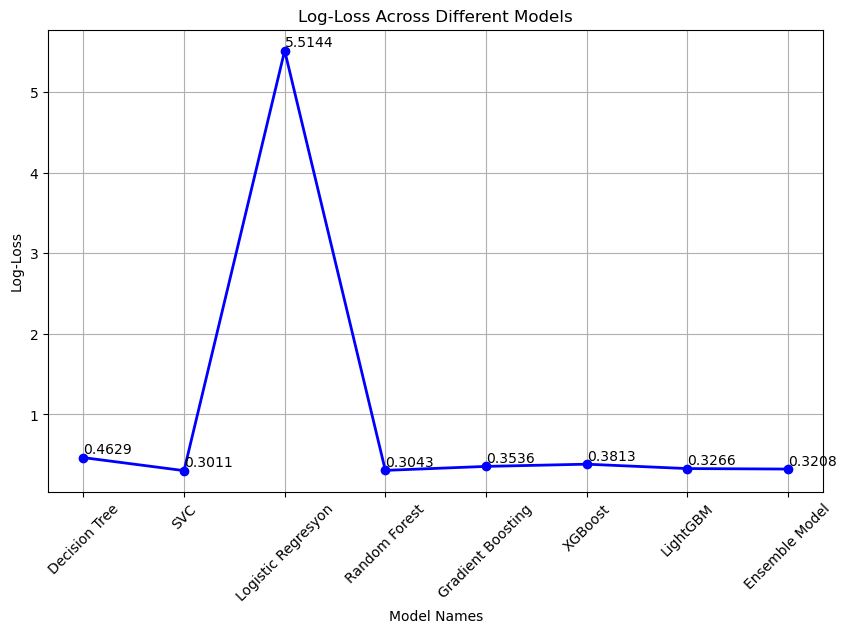

In [36]:
# Tüm modellerin doğruluk değerlerini listeleme
accuracies = {}
f1_scores = {}
log_losses = {}

model_names = [
    "Decision Tree", 
    "SVC", 
    "Logistic Regresyon", 
    "Random Forest", 
    "Gradient Boosting",
    "XGBoost", 
    "LightGBM", 
    "Ensemble Model",
]

for model_name, model in zip(model_names, best_models.values()):
    if isinstance(model, GridSearchCV):  # Eğer model GridSearchCV ise, best_estimator_ kullanılır
        model = model.best_estimator_
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)    
    accuracies[model_name] = accuracy
    f1 = f1_score(y_test, y_pred)    
    f1_scores[model_name] = f1
    logloss = log_loss(y_test, y_prob)
    log_losses[model_name] = logloss

# Accurary için çubuk grafik oluşturma
plt.figure(figsize=(10, 6))

x = list(accuracies.keys())
y = list(accuracies.values())

plt.bar(x, y, color='skyblue', edgecolor='black')

plt.xlabel('Model Names', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Model Accuracy Scores', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)  # Accuracy değerleri 0-1 arasında olduğu için limit belirliyoruz.
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, score in enumerate(y):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# F1 Score için radar chart oluşturma
labels = list(f1_scores.keys())
values = list(f1_scores.values())

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
values += values[:1]
angles += angles[:1]

plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)
ax.fill(angles, values, color='lightgreen', alpha=0.6)
ax.set_yticklabels([])  # Y eksenini gizle
ax.set_xticks(angles[:-1])
ax.set_xticklabels([])

for i, value in enumerate(values[:-1]): 
    ax.text(angles[i], value + 0.05, f'{labels[i]}: {value:.4f}', ha='center', fontsize=10, color='black')

plt.title('\nF1 Score Radar Chart\n')
plt.show()


# Log loss için çizgi grafik oluşturma
plt.figure(figsize=(10, 6))
plt.plot(list(log_losses.keys()), list(log_losses.values()), marker='o', color='b', linestyle='-', linewidth=2)
plt.xlabel('Model Names')
plt.ylabel('Log-Loss')
plt.title('Log-Loss Across Different Models')
plt.xticks(rotation=45)
plt.grid(True)

for i, value in enumerate(log_losses.values()):
    plt.text(i, value + 0.05, f'{value:.4f}', ha='left', fontsize=10, color='black')


plt.show()



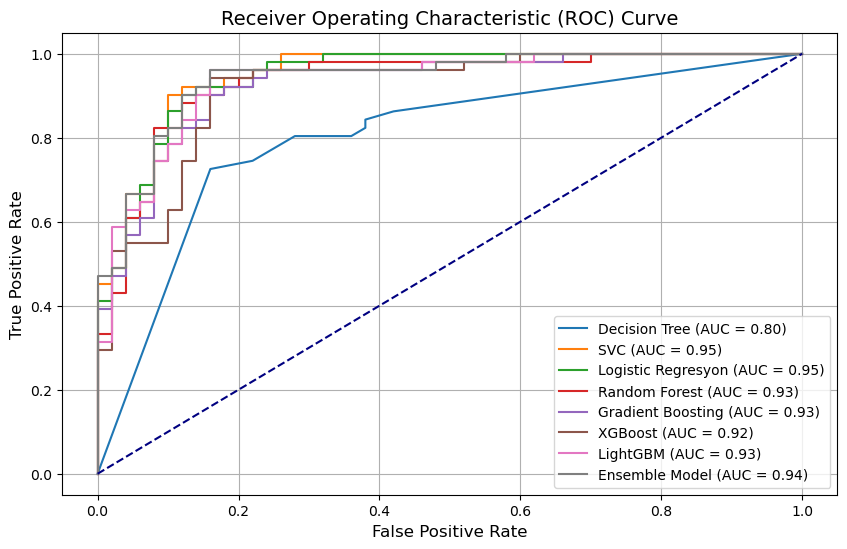

In [37]:
# ROC Curve için çizim
plt.figure(figsize=(10, 6))
for model_name in model_names:
    fpr = roc_curve(y_test, best_models[model_name].predict_proba(X_test)[:, 1])[0]
    tpr = roc_curve(y_test, best_models[model_name].predict_proba(X_test)[:, 1])[1]
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()